# Agreement between IR manual classifications and neural network

In [1]:
!pwd

/mnt/lustre02/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Classification/NN-application/NN_agreement_analysis


In [2]:
!which python

/sw/spack-rhel6/jupyterhub/jupyterhub/bin/python


In [83]:
# classification_path = '/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Data/Level_0/classifications/MODIS_NorthAtlantic/'
# classification_path_L1 = "/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Data/Level_1/classifications/"
# fn_MODIS_IR = "Classifications__NN__MODIS__IR__Region1.nc"
# fn_MODIS_VIS = "Classifications__NN__MODIS__VIS__Region1.nc"
# fn_ABI_IR = "CloudPattern__IRRetinanet__GOES16__10-24N_-61--40E__2018JFMND_2019JFMND-2020JFM.nc"


fn_ABI_IR = '/mnt/lustre02/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Data/Level_1/GOES16_CH13_classifications_2018-2020_NDJFM_30min.zarr/' #" ABIonICONdomain_DOM01.zarr'
fn_manual_classifications = '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_IR.zarr'
fn_manual_classifications = '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_VIS.zarr'
fn_manual_classifications = '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_albedo.zarr'

In [84]:
domain = [10, 24, -61, -40]  # domain of original data [lat1, lat2, lon1, lon2]
label_map= {'Sugar':0, 'Fish': 3, 'Flowers': 2, 'Flower': 2, 'Gravel': 1}
label_map_rv = {0:'Sugar', 1:'Gravel', 2: 'Flowers', 3: 'Fish'}

## Agreement between GOES_IR, MODIS_IR, MODIS_VIS

In [85]:
%load_ext autoreload
%autoreload 2
import tqdm
import dask
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

import sys, os
sys.path.append("/home/mpim/m300408/CloudClassification/sugar-flower-fish-or-gravel")
from pyclouds.imports import *
from pyclouds.helpers import *
from pyclouds.zooniverse import *
from pyclouds.plot import *

del tqdm
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Computation of masks

In [86]:
def iou_one_class_from_annos(arr1, arr2, return_iou=False):
    """
    Returns the IoU from lists of [x, y, w, h] annotations.
    Image size must be given because arrays are created internally.
    If return_iou is True, the actual IoU score is computed,
    otherwise i, u will be returned.
    
    >>> iou_one_class_from_annos([False,True],[False,False],return_iou=True)
    0.0
    >>> iou_one_class_from_annos([False,True],[True,False],return_iou=True)
    0.0
    >>> iou_one_class_from_annos([False,True],[True,True],return_iou=True)
    0.5
    >>> iou_one_class_from_annos([False,False],[False,False],return_iou=True)
    np.nan
    
    """
    i = intersect_from_arrs(arr1, arr2)
    u = union_from_arrs(arr1, arr2)
    if return_iou:
        if u > 0:
            return i/u
        # only exists in one of the inputs
        elif u == 0 and np.any([arr1, arr2]):
            return 0
        # no identifications in any input
        else:
            return np.nan
    else:
        return i, u

def intersect_from_arrs(arr1, arr2):
    """Applies bitwise_and followed by a sum. Note that the sum operation is expensive."""
    return np.count_nonzero(np.bitwise_and(arr1, arr2))


def union_from_arrs(arr1, arr2):
    """Applies bitwise_or followed by a sum. Note that the sum operation is expensive."""
    return np.count_nonzero(np.bitwise_or(arr1, arr2))

def get_date_from_filename(fn):
    fn_parts = fn.split('/')
    try:
        date = dt.datetime.strptime(fn_parts[-1].split('_')[4], 'Day%Y%m%d')
    except ValueError:
        date = dt.datetime.strptime(fn_parts[-1].split('_')[-3], 'TrueColor%Y%m%d')
    return date

def create_mask(boxes, labels, out, label_map={'Sugar':0, 'Fish': 3, 'Flower': 2, 'Gravel': 1}):
    """
    Create or add mask to array
    """
    xy_boxes = [wh2xy(*b) for b in boxes]
    
    for l, lab in enumerate(labels):
        mask_layer = label_map[lab]
        x1,y1,x2,y2 = np.array(xy_boxes[l]).astype(int)
        out[x1:x2,y1:y2,mask_layer] = True
    
    return out

## Calculate IoUs

In [87]:
import tqdm
import datetime as dt
import numpy as np
import dask
import pandas as pd
import zarr
import xarray as xr
import os

In [88]:
mask_ABI_IR = xr.open_zarr(fn_ABI_IR)
if '.zarr' in fn_manual_classifications:
    mask_manual_classifications = xr.open_zarr(fn_manual_classifications)
elif '.nc' in fn_manual_classifications:
    mask_manual_classifications = xr.open_dataset(fn_manual_classifications)
else:
    print('File format not supported')
# mask_ICON_IR_DOM02 = xr.open_zarr(fn_ICON_IR_DOM02)
# mask_ABI_IR_DOM02 = xr.open_zarr(fn_ABI_IR_DOM02)

In [89]:
mask_manual_classifications.date

<xarray.DataArray 'date' (date: 564)>
array(['2020-01-07T00:00:00.000000000', '2020-01-07T02:00:00.000000000',
       '2020-01-07T04:00:00.000000000', ..., '2020-02-22T18:00:00.000000000',
       '2020-02-22T20:00:00.000000000', '2020-02-22T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2020-01-07 ... 2020-02-22T22:00:00
Attributes:
    standard_name:  time

In [90]:
mask_ABI_IR

,Array,Chunk
Bytes,1.47 TiB,89.72 MiB
Shape,"(17144, 2100, 1400, 4)","(1, 2100, 1400, 4)"
Count,17145 Tasks,17144 Chunks
Type,object,numpy.ndarray


In [91]:
def interSection(arr1,arr2): # finding common elements
    print('yey')
    values = list(filter(lambda x: x in arr1, arr2))
    print('whuhu')
    return values

def merge_mask(mask):
    """Merge mask along time dimension (has to be first dimension)
    """
    return np.any(~np.isnan(mask.astype("float")), axis=0)

def iou_one_class_from_annos(arr1, arr2, return_iou=False):
    """
    Returns the IoU from lists of [x, y, w, h] annotations.
    Image size must be given because arrays are created internally.
    If return_iou is True, the actual IoU score is computed,
    otherwise i, u will be returned.
    
    >>> iou_one_class_from_annos([False,True],[False,False],return_iou=True)
    0.0
    >>> iou_one_class_from_annos([False,True],[True,False],return_iou=True)
    0.0
    >>> iou_one_class_from_annos([False,True],[True,True],return_iou=True)
    0.5
    >>> iou_one_class_from_annos([False,False],[False,False],return_iou=True)
    np.nan
    
    """
    i = intersect_from_arrs(arr1, arr2)
    u = union_from_arrs(arr1, arr2)
    if return_iou:
        if u > 0:
            return i/u
        # only exists in one of the inputs
        elif u == 0 and np.any([arr1, arr2]):
            return 0
        # no identifications in any input
        else:
            return np.nan
    else:
        return i, u

def intersect_from_arrs(arr1, arr2):
    """Applies bitwise_and followed by a sum. Note that the sum operation is expensive."""
    return np.sum(np.bitwise_and(arr1, arr2))


def union_from_arrs(arr1, arr2):
    """Applies bitwise_or followed by a sum. Note that the sum operation is expensive."""
    return np.sum(np.bitwise_or(arr1, arr2))


def identify_where_class_missing(arr1,arr2):
    """
    Identify which input array does not contain
    any labels.
    >>> identify_where_class_missing([[True, False],[True, False]],[[False, False],[False, False]])
    2
    >>> identify_where_class_missing([False],[True])
    1
    >>> identify_where_class_missing([False],[False])
    3
    >>> identify_where_class_missing([True],[True])
    0
    """
    missing_arr1 = not np.any(arr1)
    missing_arr2 = not np.any(arr2)
    if not missing_arr1 and not missing_arr2:
        return 0
    elif missing_arr1 and not missing_arr2:
        return 1
    elif missing_arr2 and not missing_arr1:
        return 2
    elif missing_arr1 and missing_arr2:
        return 3

In [92]:
# lat0, lat1, lon0, lon1 = [7.5, 17, -60.25, -45]
lat0, lat1, lon0, lon1 = [10, 20, -58, -48]

In [93]:
color_dict = {'Sugar':'#A1D791','Fish':'#2281BB','Gravel':'#3EAE47', 'Flowers': '#93D2E2'}

In [94]:
# time_set_A = set(mask_ABI_IR.time.dt.floor(freq='1D').values)
time_set_A = set(mask_ABI_IR.time.dt.floor(freq='1T').values)
time_set_B = set(mask_manual_classifications.date.values)
common_dates = np.array([*time_set_A.intersection(time_set_B)])

In [95]:
len(common_dates)/12

46.583333333333336

In [96]:
# time_mask_ABIIR = np.in1d(mask_ABI_IR.time.dt.floor(freq='1D').values,common_dates)
time_mask_ABIIR = np.in1d(mask_ABI_IR.time.dt.floor(freq='1T').values,common_dates)

In [97]:
mask_ABI_IR_timesel = mask_ABI_IR.sel(time=time_mask_ABIIR)
# mask_ABI_IR_timesel['date'] = mask_ABI_IR_timesel.time.dt.floor(freq='1D')
mask_ABI_IR_timesel['date'] = mask_ABI_IR_timesel.time.dt.floor(freq='1T')

In [98]:
mask_manual_timesel = mask_manual_classifications.sel(date=common_dates)

In [99]:
results = {}

print("Find common times to all datasets")
times_of_interest = sorted(np.unique(common_dates))

sizes_calculated = False

for ii, i in enumerate(tqdm.tqdm(range(len(times_of_interest)))):
    mask_ABI_IR_timestep = mask_ABI_IR_timesel.where(mask_ABI_IR_timesel.date == times_of_interest[i], drop=True)
    mask_manual_timestep = mask_manual_timesel.sel(date=times_of_interest[i])
    


    mask_ABI_IR_timestep = mask_ABI_IR_timestep.sel(latitude=slice(lat1, lat0),longitude=slice(lon0, lon1))
    mask_manual_timestep = mask_manual_timestep.sel(latitude=slice(lat1, lat0),longitude=slice(lon0, lon1))
        
    if sizes_calculated is False:
        size_ABI = len(mask_ABI_IR_timestep.latitude)*len(mask_ABI_IR_timestep.longitude)
        size_manual = len(mask_manual_timestep.latitude)*len(mask_manual_timestep.longitude)
        sizes_calculated = True
        
# for d, date in enumerate(tqdm.tqdm(dates_in_all_datasets)):
    pattern_results = {}
    
    for pattern in ['Sugar', 'Gravel', 'Flowers', 'Fish']:
        arr_ABI = mask_ABI_IR_timestep.mask.sel(pattern=pattern)
        arr_manual = mask_manual_timestep.freq.sel(pattern=pattern)
        pattern_results[pattern] = {}
        
        merged_mask_ABI = merge_mask(arr_ABI)
        merged_mask_manual = arr_manual > 0.1 #merge_mask(arr_ABI_IR)
        
        merged_mask_ABI = merged_mask_ABI.fillna(False).astype(bool).load()
        merged_mask_manual = merged_mask_manual.load()
        
        pattern_results[pattern]["area_fraction_ABI"] = np.count_nonzero(merged_mask_ABI)/size_ABI
        pattern_results[pattern]["area_fraction_Manual"] = np.count_nonzero(merged_mask_manual)/size_manual
        
#         iou_ABI_Manual = iou_one_class_from_annos(merged_mask_ABI.values,
#                                                 merged_mask_manual.values,
#                                                 return_iou = True)
#         print(iou_ABI_Manual)
#         pattern_results[pattern]["iou_ABI_Manual"] = iou_ABI_Manual
        pattern_results[pattern]["missing_ABI_Manual"] = identify_where_class_missing(merged_mask_ABI,
                                                                                    merged_mask_manual)
        
    
    results[times_of_interest[i]] = pattern_results

  0%|          | 0/559 [00:00<?, ?it/s]

Find common times to all datasets


100%|██████████| 559/559 [47:13<00:00,  5.07s/it] 


In [100]:
df = pd.DataFrame.from_dict(results, orient='index')
df.to_pickle('agreement_results_ABI-IR_vs_manualICONalb_20211117.pkl')

df = pd.DataFrame.from_dict(results, orient='index')
df.to_pickle('agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_{n:04d}_20210511.pkl'.format(n=d))## Analyze agreement

In [103]:
import glob

In [104]:
!ls agreement_results*

agreement_results_ABI-IR_vs_ICON-DOM01_20210930.pkl
agreement_results_ABI-IR_vs_ICON-DOM01_20211003.pkl
agreement_results_ABI-IR_vs_ICON-DOM02_20211006.pkl
agreement_results_ABI-IR_vs_ICON-DOM02_20211007.pkl
agreement_results_ABI-IR_vs_manual_20211111.pkl
agreement_results_ABI-IR_vs_manual_20211112.pkl
agreement_results_ABI-IR_vs_manualICONalb_20211117.pkl
agreement_results_ABI-IR_vs_manualVIS_20211117.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0100_20210511.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0100.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0200_20210511.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0200.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0300_20210511.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0300.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0332_20210511.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0400.pkl
agreement_results_MODIS_IR_vs_MODIS_VIS_vs_ABI_IR_0500.pkl
agreement_results_MODIS

In [125]:
def rename_keys(dic, string):
    if isinstance(dic, dict):
        dic_new = {}
        for k,v in dic.items():
            dic_new[k.replace('Manual',string)] = v
        return dic_new
    return dic

In [143]:
# Read output created by agreement_NN.py
agreement_files = np.array(sorted(glob.glob("agreement_results_ABI-IR_vs_manual*_2021111[27].pkl")))
# agreement_files = np.array(sorted(glob.glob("agreement_results_ABI-IR_vs_manual_20211112.pkl")))
# agreement_files = np.array(sorted(glob.glob("agreement_results_ABI-IR_vs_manual_20211111.pkl")))
# agreement_files = np.array(sorted(glob.glob("agreement_results_ABI-IR_vs_ICON-DOM02_20211007.pkl")))
print(agreement_files)
dataframes = [None]*len(agreement_files)
for f,file in enumerate(agreement_files):
    dataframes[f] = pd.read_pickle(file)
    if 'manualVIS' in file:
        dataframes[f]=dataframes[f].applymap(lambda x: rename_keys(x, 'ManualVIS'))
    elif 'manualICONalb' in file:
        dataframes[f]=dataframes[f].applymap(lambda x: rename_keys(x, 'ManualICON'))

['agreement_results_ABI-IR_vs_manualICONalb_20211117.pkl'
 'agreement_results_ABI-IR_vs_manualVIS_20211117.pkl'
 'agreement_results_ABI-IR_vs_manual_20211112.pkl']
moya
eya


In [127]:
pd.__version__

'1.3.4'

In [144]:
df_all = pd.concat(dataframes);
df_all.head()

,Sugar,Gravel,Flowers,Fish
2020-01-07 02:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.82656, 'area_fraction_...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu..."
2020-01-07 04:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.9, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu..."
2020-01-07 06:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.784131, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu..."
2020-01-07 08:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.800765, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu..."
2020-01-07 10:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.817747, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu...","{'area_fraction_ABI': 0.0, 'area_fraction_Manu..."


In [145]:
mask = (df_all.index >= '2020-01-07') & (df_all.index <= '2020-02-22')
# IOP
#20 January and 20 February 2020
# mask = (df_all.index >= '2020-01-20') & (df_all.index <= '2020-02-20')

In [146]:
df_all = df_all.loc[mask]

In [147]:
Sugar_df = df_all.Sugar.apply(pd.Series)
Gravel_df = df_all.Gravel.apply(pd.Series)
Flowers_df = df_all.Flowers.apply(pd.Series)
Fish_df = df_all.Fish.apply(pd.Series)

In [148]:
for df,p in zip([Sugar_df, Gravel_df, Fish_df, Flowers_df], ['Sugar','Gravel','Fish','Flowers']):
    rename_dict = {}
    for c in df.columns:
        rename_dict[c]=p+"_"+c
    df.rename(columns=rename_dict, inplace=True)

In [149]:
from functools import reduce
df_all = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                            how='outer'), [Sugar_df, Gravel_df, Flowers_df, Fish_df])

In [150]:
df_all

,Sugar_area_fraction_ABI,Sugar_area_fraction_ManualICON,Sugar_missing_ABI_ManualICON,Sugar_area_fraction_ManualVIS,Sugar_missing_ABI_ManualVIS,Sugar_area_fraction_Manual,Sugar_iou_ABI_Manual,Sugar_missing_ABI_Manual,Gravel_area_fraction_ABI,Gravel_area_fraction_ManualICON,...,Flowers_iou_ABI_Manual,Flowers_missing_ABI_Manual,Fish_area_fraction_ABI,Fish_area_fraction_ManualICON,Fish_missing_ABI_ManualICON,Fish_area_fraction_ManualVIS,Fish_missing_ABI_ManualVIS,Fish_area_fraction_Manual,Fish_iou_ABI_Manual,Fish_missing_ABI_Manual
2020-01-07 02:00:00,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.826560,0.0,...,NaN,NaN,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
2020-01-07 02:00:00,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.826560,0.0,...,NaN,NaN,0.0,NaN,NaN,0.0,3.0,NaN,NaN,NaN
2020-01-07 02:00:00,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.826560,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,3.0
2020-01-07 02:00:00,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.826560,0.0,...,NaN,NaN,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
2020-01-07 02:00:00,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.826560,0.0,...,NaN,NaN,0.0,NaN,NaN,0.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-22 00:00:00,0.548682,NaN,NaN,NaN,NaN,0.299228,0.383417,0.0,0.338272,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,3.0,NaN,NaN,NaN
2020-02-22 00:00:00,0.548682,NaN,NaN,NaN,NaN,0.299228,0.383417,0.0,0.338272,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.342138,0.0,1.0
2020-02-22 00:00:00,0.548682,NaN,NaN,NaN,NaN,0.299228,0.383417,0.0,0.338272,NaN,...,NaN,3.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
2020-02-22 00:00:00,0.548682,NaN,NaN,NaN,NaN,0.299228,0.383417,0.0,0.338272,NaN,...,NaN,3.0,0.0,NaN,NaN,0.0,3.0,NaN,NaN,NaN


Note:
- nan values occur when the pattern has not been identified in any of the cases
- 0 occurs, if there has been no overlap between classes, which can also happen when one NN doesn't detect the pattern at all

## Area fractions

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

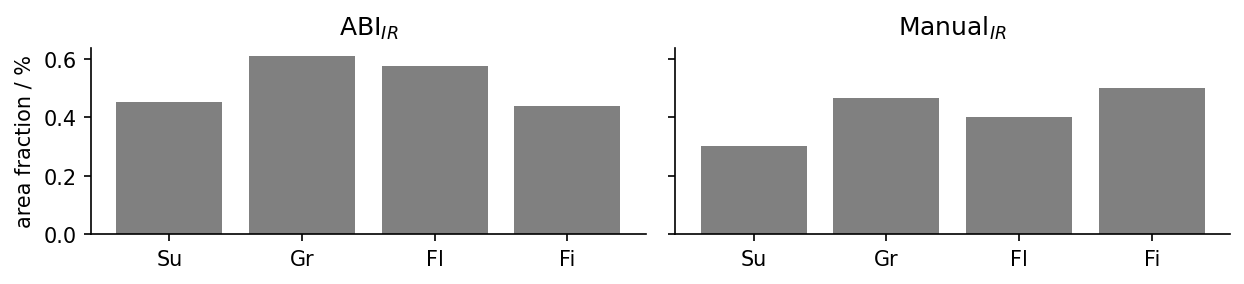

In [41]:
prop_dict = {
    "Manual":{
        'title': "Manual$_{IR}$"
    },
    "ABI":{
        'title': "ABI$_{IR}$"
    }
}
fig, axs = plt.subplots(1,2,figsize=(8.4,2),dpi=150,sharey=True)
for a,classification_approach in enumerate(["ABI", "Manual"]):
    means = {}
    for p, pattern in enumerate(['Sugar','Gravel','Flowers','Fish']):
        means[pattern]=df_all[pattern+'_area_fraction_'+classification_approach].loc[df_all[pattern+'_area_fraction_'+classification_approach] != 0].mean()
        axs[a].bar(p, means[pattern],color='grey')
    if a == 0:
        axs[a].set_ylabel('area fraction / %')
    axs[a].set_title(prop_dict[classification_approach]['title'])
    sns.despine()
    plt.tight_layout()
    axs[a].set_xticks([0,1,2,3])
    axs[a].set_xticklabels(['Su','Gr','Fl','Fi'])
# plt.savefig('areafraction_comparisons.pdf',bbox_inches="tight")

### Daily distribution

In [152]:
df_daily_mean = df_all.resample('1D').mean()

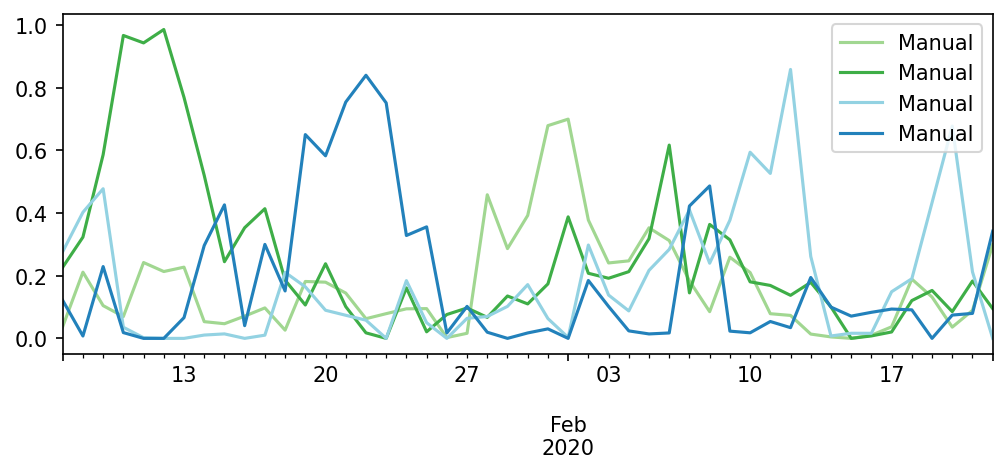

In [72]:
plt.figure(figsize=(8,3), dpi=150)
for pattern in ['Sugar', 'Gravel', 'Flowers', 'Fish']:
#     df_daily_mean[f'{pattern}_area_fraction_ABI'].plot(label='ABI', color=color_dict[pattern], linestyle='--')
    df_daily_mean[f'{pattern}_area_fraction_Manual'].plot(label='Manual', color=color_dict[pattern], linestyle='-')
plt.legend()

In [135]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      color=color_dict,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if H is not None:
                    rect.set_hatch(H * int(i / n_col)) #edited part
                rect.set_edgecolor('white')
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks(((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)[::2])
    axe.set_xticks(((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.), minor=True)
    axe.set_xticklabels(df.index.date[::2], rotation = 90)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        if H is None:
            n.append(axe.bar(0, 0, color="gray", edgecolor='white'))
        else:
            n.append(axe.bar(0, 0, color="gray", hatch=H * int(i), edgecolor='white'))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

In [153]:
df0 = df_all.filter(items=['Sugar_area_fraction_Manual','Gravel_area_fraction_Manual','Flowers_area_fraction_Manual','Fish_area_fraction_Manual']).rename(
    columns={'Sugar_area_fraction_Manual':'Sugar',
             'Gravel_area_fraction_Manual':'Gravel',
             'Flowers_area_fraction_Manual':'Flowers',
             'Fish_area_fraction_Manual':'Fish'})

In [154]:
df1 = df_daily_mean.filter(items=['Sugar_area_fraction_ABI','Gravel_area_fraction_ABI','Flowers_area_fraction_ABI','Fish_area_fraction_ABI']).rename(
    columns={'Sugar_area_fraction_ABI':'Sugar',
             'Gravel_area_fraction_ABI':'Gravel',
             'Flowers_area_fraction_ABI':'Flowers',
             'Fish_area_fraction_ABI':'Fish'})

In [155]:
df2 = df_daily_mean.filter(items=['Sugar_area_fraction_Manual','Gravel_area_fraction_Manual','Flowers_area_fraction_Manual','Fish_area_fraction_Manual']).rename(
    columns={'Sugar_area_fraction_Manual':'Sugar',
             'Gravel_area_fraction_Manual':'Gravel',
             'Flowers_area_fraction_Manual':'Flowers',
             'Fish_area_fraction_Manual':'Fish'})

In [156]:
df3 = df_daily_mean.filter(items=['Sugar_area_fraction_ManualVIS','Gravel_area_fraction_ManualVIS','Flowers_area_fraction_ManualVIS','Fish_area_fraction_ManualVIS']).rename(
    columns={'Sugar_area_fraction_ManualVIS':'Sugar',
             'Gravel_area_fraction_ManualVIS':'Gravel',
             'Flowers_area_fraction_ManualVIS':'Flowers',
             'Fish_area_fraction_ManualVIS':'Fish'})

In [157]:
df4 = df_daily_mean.filter(items=['Sugar_area_fraction_ManualICON','Gravel_area_fraction_ManualICON','Flowers_area_fraction_ManualICON','Fish_area_fraction_ManualICON']).rename(
    columns={'Sugar_area_fraction_ManualICON':'Sugar',
             'Gravel_area_fraction_ManualICON':'Gravel',
             'Flowers_area_fraction_ManualICON':'Flowers',
             'Fish_area_fraction_ManualICON':'Fish'})

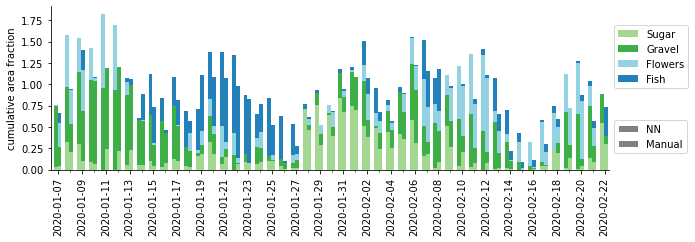

In [54]:
p=plot_clustered_stacked([df1, df2],["NN", "Manual"],title=None,figsize=(10,3),H=None)
p.set_ylabel('cumulative area fraction')
sns.despine()
plt.savefig('./figures/cumulative_area_fraction_ABIvsManual_dailyindividual2h.pdf', bbox_inches='tight')

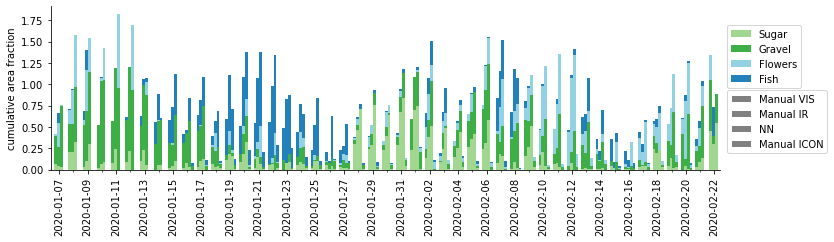

In [163]:
p=plot_clustered_stacked([df3, df2, df1, df4],["Manual VIS", "Manual IR", "NN", "Manual ICON"],title=None,figsize=(12,3),H=None)
p.set_ylabel('cumulative area fraction')
sns.despine()
plt.savefig('./figures/cumulative_area_fraction_ManualVISvsManualIRvsNNvsICON_dailyindividual2h.pdf', bbox_inches='tight')

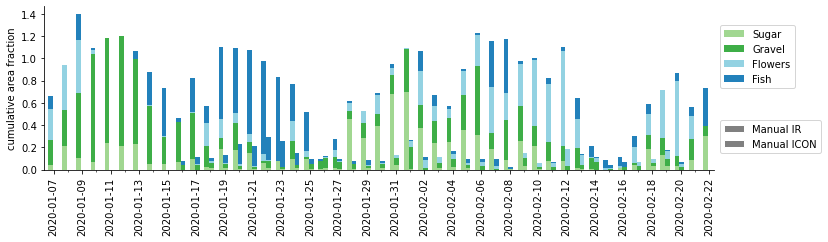

In [164]:
p=plot_clustered_stacked([df2, df4],["Manual IR", "Manual ICON"],title=None,figsize=(12,3),H=None)
p.set_ylabel('cumulative area fraction')
sns.despine()
# plt.savefig('./figures/cumulative_area_fraction_ManualVISvsManualIRvsNNvsICON_dailyindividual2h.pdf', bbox_inches='tight')

## Where do IoUs of 0 come from?

In [34]:
df_all

,Sugar_area_fraction_ABI,Sugar_area_fraction_Manual,Sugar_iou_ABI_Manual,Sugar_missing_ABI_Manual,Gravel_area_fraction_ABI,Gravel_area_fraction_Manual,Gravel_iou_ABI_Manual,Gravel_missing_ABI_Manual,Flowers_area_fraction_ABI,Flowers_area_fraction_Manual,Flowers_iou_ABI_Manual,Flowers_missing_ABI_Manual,Fish_area_fraction_ABI,Fish_area_fraction_Manual,Fish_iou_ABI_Manual,Fish_missing_ABI_Manual
2020-01-07 02:00:00,0.000000,0.122568,0.000000,1.0,0.826560,0.337125,0.399939,0.0,0.0,0.000000,NaN,3.0,0.000000,0.000000,NaN,3.0
2020-01-07 04:00:00,0.000000,0.044850,0.000000,1.0,0.900000,0.712167,0.791297,0.0,0.0,0.000000,NaN,3.0,0.000000,0.481328,0.0,1.0
2020-01-07 06:00:00,0.000000,0.000000,NaN,3.0,0.784131,0.116885,0.149063,0.0,0.0,0.000000,NaN,3.0,0.000000,0.000000,NaN,3.0
2020-01-07 08:00:00,0.000000,0.000000,NaN,3.0,0.800765,0.461606,0.576456,0.0,0.0,0.804579,0.0,1.0,0.000000,0.000000,NaN,3.0
2020-01-07 10:00:00,0.000000,0.000000,NaN,3.0,0.817747,0.065664,0.080299,0.0,0.0,0.783265,0.0,1.0,0.000000,0.000000,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-21 16:00:00,0.000000,0.255902,0.000000,1.0,0.472397,0.669024,0.683917,0.0,0.0,0.000000,NaN,3.0,0.281888,0.000000,0.0,2.0
2020-02-21 18:00:00,0.473880,0.000000,0.000000,2.0,0.460902,0.000000,0.000000,2.0,0.0,0.000000,NaN,3.0,0.152716,0.000000,0.0,2.0
2020-02-21 20:00:00,0.445314,0.273215,0.173091,0.0,0.000000,0.388713,0.000000,1.0,0.0,0.000000,NaN,3.0,0.000000,0.299123,0.0,1.0
2020-02-21 22:00:00,0.558688,0.497605,0.510602,0.0,0.000000,0.287390,0.000000,1.0,0.0,0.000000,NaN,3.0,0.000000,0.658064,0.0,1.0


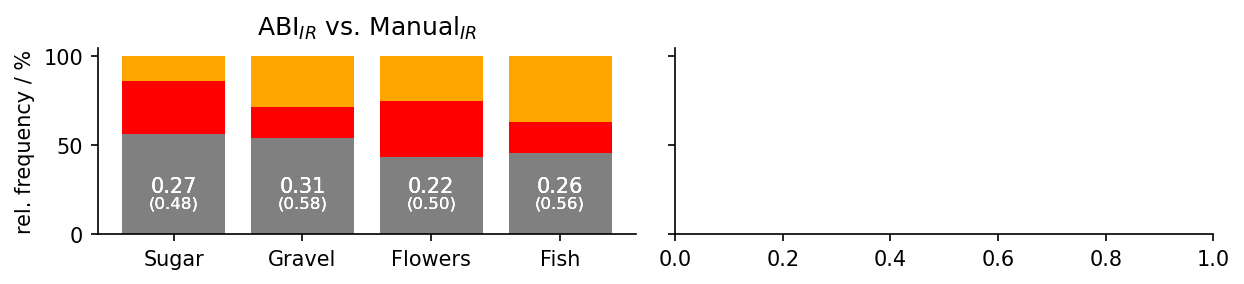

In [35]:
prop_dict = {
    "ABI_Manual":{
        'colors': ['grey','red' , 'orange', 'green'],
        'title': 'ABI$_{IR}$ vs. Manual$_{IR}$'},
    "MVIS_AIR":{
        'colors': ['grey', 'blue','orange', 'green'],
        'title': 'MODIS$_{VIS}$ vs. ABI$_{IR}$'},
    "MIR_AIR":{
        'colors':['grey', 'red' ,'orange', 'green'],
        'title': 'MODIS$_{IR}$ vs. ABI$_{IR}$'}
    
}

relative = True
fig,axs = plt.subplots(1,2,figsize=(8.4,2),dpi=150,sharey=True)
for cc, classification_comparison in enumerate(["ABI_Manual"]):
    colors = prop_dict[classification_comparison]['colors']
    means = {}
    for p, pattern in enumerate(['Sugar','Gravel','Flowers','Fish']):
        total = np.count_nonzero(np.where(df_all[pattern+'_missing_'+classification_comparison].dropna() != 3,True,False))
        if total == 0:
            continue
        counts = np.zeros(4)
        iou_without_zeros = df_all[pattern+'_iou_'+classification_comparison].loc[df_all[pattern+'_missing_'+classification_comparison] ==0].mean()
        iou_with_zeros = df_all[pattern+'_iou_'+classification_comparison].mean()
        for i_,i in enumerate([0,1,2,3]): #0: missing in none; 3: missing in both; 2:missing in the second (AIR)
            c=np.count_nonzero(np.where(df_all[pattern+'_missing_'+classification_comparison].dropna() == i,True,False))
            if relative:
                c = c/total*100
            counts[i_] = c
            if i == 3:
                continue
            if i_ == 0:
                axs[cc].bar(p, c, color=colors[i], label='no classifications')
            else:
                axs[cc].bar(p, c, bottom=np.sum(counts[0:i_]), color=colors[i])
            axs[cc].text(p,24, "{:3.2f}".format(iou_with_zeros),ha='center',color='white')
            axs[cc].text(p,15, "({:3.2f})".format(iou_without_zeros),ha='center',color='white',fontsize=8)
            axs[cc].set_title(prop_dict[classification_comparison]['title'])
    axs[cc].set_xticks([0,1,2,3])
    axs[cc].set_xticklabels(['Sugar','Gravel','Flowers','Fish'])
    if cc == 0:
        axs[cc].set_ylabel('rel. frequency / %')
    sns.despine()
    plt.tight_layout()
# plt.savefig(f'IOU_comparisons_mean_DOM0{DOM}.pdf',bbox_inches="tight")

## Comparison with Iorg

In [5]:
import datetime as dt
import numpy as np
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

In [6]:
fn_iorg = '/work/mh0010/m300408/EUREC4A_CloudClassification/metrics/GOES16_IR_nc_Iorg_EUREC4A_10-20_-58--48.nc'

In [7]:
ds_iorg = xr.open_dataset(fn_iorg)

In [18]:
contaminated_dates = np.unique(ds_iorg.where(ds_iorg.percentile_Tb < 285, drop=True).time.dt.date)

In [62]:
ds_iorg_sel = ds_iorg.sel(time=~np.in1d(ds_iorg.time.dt.date,contaminated_dates), drop=True)
ds_iorg_sel = ds_iorg_sel.sel(time=np.in1d(ds_iorg_sel.time.dt.date,np.unique(df_all.index.date)))

In [63]:
ds_iorg_mean = ds_iorg_sel.groupby(ds_iorg_sel.time.dt.date).mean()
# ds_iorg_mean = ds_iorg.groupby(ds_iorg.time.dt.date).mean()

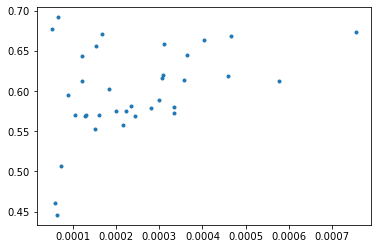

In [64]:
plt.plot(ds_iorg_mean.cluster_size_mean, ds_iorg_mean.Iorg,'.')

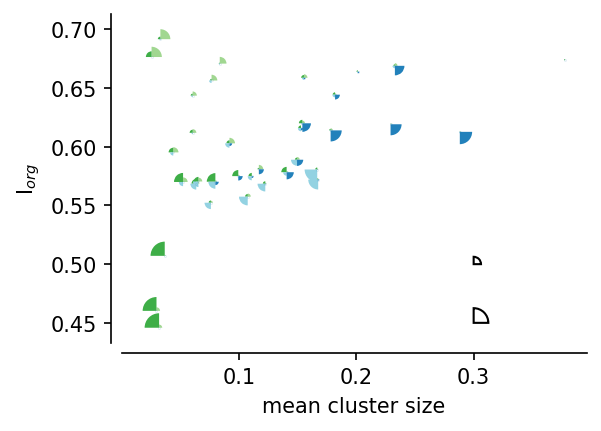

In [67]:
fig, ax = plt.subplots(figsize=(4,4),dpi=150)

patches = []



ax.plot(ds_iorg_mean.cluster_size_mean*500, ds_iorg_mean.Iorg,'.', markersize=0.1)
ax.set_aspect(1)

for t, (y,x) in enumerate(zip(ds_iorg_mean.cluster_size_mean.values*500, ds_iorg_mean.Iorg.values)):
#     if t>15:continue
    date = ds_iorg_mean.isel(date=t).date.values
    date = dt.datetime.combine(date.item(), dt.datetime.min.time())
    try:
        data = df2.loc[date]
    except KeyError:
        continue
# Some limiting conditions on Wedge
    for p_,pattern in enumerate(['Sugar','Gravel', 'Flowers','Fish']):
        w = Wedge((y, x), data[pattern]/80, p_*90, (p_+1)*90, fc=color_dict[pattern])

        ax.add_patch(w)

w = Wedge((.3, .45), 1/80, 0, 90, fc='white',ec='k', transform=ax.transData)
ax.add_patch(w)
w = Wedge((.3, .50), 0.5/80, 0, 90, fc='white',ec='k', transform=ax.transData)
ax.add_patch(w)

# p = PatchCollection(patches, alpha=1)
# ax.add_collection(p)
plt.xlabel('mean cluster size')
plt.ylabel('I$_{org}$')
sns.despine(offset=5)
plt.savefig('./figures/Iorg_vs_S_hueManualClassifications.pdf', bbox_inches="tight")

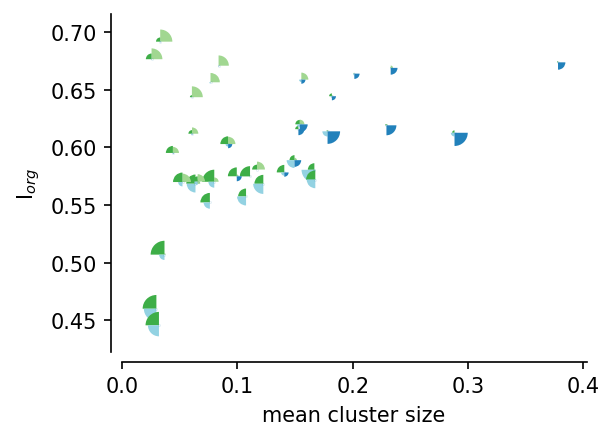

In [68]:
fig, ax = plt.subplots(figsize=(4,4),dpi=150)

patches = []



ax.plot(ds_iorg_mean.cluster_size_mean*500, ds_iorg_mean.Iorg,'.', markersize=0.1)
ax.set_aspect(1)

for t, (y,x) in enumerate(zip(ds_iorg_mean.cluster_size_mean.values*500, ds_iorg_mean.Iorg.values)):
#     if t>15:continue
    date = ds_iorg_mean.isel(date=t).date.values
    date = dt.datetime.combine(date.item(), dt.datetime.min.time())
    try:
        data = df1.loc[date]
    except KeyError:
        continue
# Some limiting conditions on Wedge
    for p_,pattern in enumerate(['Sugar','Gravel', 'Flowers','Fish']):
        w = Wedge((y, x), data[pattern]/80, p_*90, (p_+1)*90, fc=color_dict[pattern])

        ax.add_patch(w)


plt.xlabel('mean cluster size')
plt.ylabel('I$_{org}$')
sns.despine(offset=5)
plt.savefig('./figures/Iorg_vs_S_hueNN.pdf', bbox_inches="tight")